In [7]:
%pip install wbdata prophet statsmodels scikit-learn matplotlib

  Using cached wbdata-1.1.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached prophet-1.2.1-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached backoff-2.2.1-py3-none-any.whl.metadata (14 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached dateparser-1.2.2-py3-none-any.whl.metadata (29 kB)
  Using cached shelved_cache-0.3.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached tzlocal-5.3.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached cmdstanpy-1.3.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached wbdata-1.1.0-py3-none-any.whl (18 kB)
Using cached backoff-2.2.1-py3-none-any.whl (15 kB)
Using cached cachetools-5.5.2-py3-none-any.whl (10 kB)
Using cached dateparser-1.2.2-py3-none-any.whl (315 kB)
Using cached shelved_cache-0.3.1-py3-none-any.whl (7.8

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# Nominal GDP Forecast Analysis (Top 50 Countries)

This notebook implements a hybrid forecasting system using **Prophet** (Facebook) and **ARIMA**. It fetches GDP data from the World Bank, processes it, and generates a 5-year forecast for top 50 economies.

**Methodology:**
1.  **Data**: World Bank GDP (current US$) data (2010-2025).
2.  **Preprocessing**: Log-transformation and missing value interpolation.
3.  **Models**:
    *   **Prophet**: Tuned for economy types (Stable, High Growth, Emerging). Includes a "pandemic" regressor.
    *   **ARIMA**: Captures residual autocorrelations.
4.  **Ensemble**: Weighted average of models based on time-series cross-validation performance.

In [8]:
import pandas as pd
import numpy as np
import wbdata
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime
import os
import warnings
import logging

# Suppress warnings
warnings.filterwarnings("ignore")
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Configuration
TOP_50_ISO = [
    "USA", "CHN", "JPN", "DEU", "IND", "GBR", "FRA", "BRA", "ITA", "CAN",
    "RUS", "KOR", "AUS", "MEX", "ESP", "IDN", "SAU", "TUR", "NLD", "CHE",
    "POL", "ARG", "SWE", "BEL", "THA", "IRN", "AUT", "NOR", "ARE", "NGA",
    "ISR", "IRL", "ZAF", "SGP", "PHL", "VNM", "MYS", "BGD", "EGY", "HKG",
    "DNK", "COL", "PAK", "CHL", "FIN", "CZE", "PRT", "ROU", "PER", "IRQ"
]

ECONOMY_TYPES = {
    "Stable": ["USA", "DEU", "JPN", "GBR", "FRA", "CAN", "AUS", "ITA", "ESP", "NLD", "CHE", "SWE", "BEL", "AUT", "NOR", "ISR", "IRL", "DNK", "FIN", "PRT"],
    "High_Growth": ["CHN", "IND", "VNM", "IDN", "BGD", "PHL", "MYS"],
    "Emerging": ["BRA", "MEX", "TUR", "POL", "ARG", "THA", "SAU", "ZAF", "EGY", "COL", "PAK", "CHL", "ROM", "PER", "NGA", "RUS", "IRN"]
}

FORECAST_YEARS = 5
START_YEAR = 2010
END_YEAR = 2025

DATA_DIR = "data"
MODELS_DIR = "models"
FORECASTS_DIR = "forecasts"

# Ensure directories exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FORECASTS_DIR, exist_ok=True)

c:\Users\DKS\Desktop\VSC\Nov25\conda-grib\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Acquisition
We fetch historical GDP data (indicator: `NY.GDP.MKTP.CD`) from the World Bank API using the `wbdata` library. The data is cached locally to avoid repeated API calls.

In [14]:
def fetch_gdp_data(countries):
    print(f"Fetching GDP data from World Bank for {len(countries)} countries...")
    data_date = (datetime.datetime(START_YEAR, 1, 1), datetime.datetime(END_YEAR, 12, 31))
    
    # NY.GDP.MKTP.CD = GDP (current US$)
    try:
        # Attempt minimal call or use correct argument if known. 
        # wbdata v1+ might behave differently, but let's try 'date' or just omitting it and filtering.
        # Common argument is 'date' or 'data_date' depending on version.
        try:
             raw_data = wbdata.get_dataframe({"NY.GDP.MKTP.CD": "GDP"}, country=countries, data_date=data_date)
        except TypeError:
             print("Retrying with 'date' argument...")
             raw_data = wbdata.get_dataframe({"NY.GDP.MKTP.CD": "GDP"}, country=countries, date=data_date)
            
        raw_data.reset_index(inplace=True)
        raw_data['date'] = pd.to_datetime(raw_data['date'])
        raw_data['GDP'] = raw_data['GDP'].astype(float)
        
        # Save to cache
        cache_path = os.path.join(DATA_DIR, "wbdata_gdp_2010_2025.csv")
        raw_data.to_csv(cache_path, index=False)
        print(f"Data saved to {cache_path}")
        return raw_data
    except Exception as e:
        print(f"Error fetching data: {e}")
        # Return dummy data to prevent downstream crash if failure persists
        return pd.DataFrame(columns=['country', 'date', 'GDP'])

# Load Data
data_path = os.path.join(DATA_DIR, "wbdata_gdp_2010_2025.csv")
if os.path.exists(data_path):
    print("Loading data from local cache...")
    df = pd.read_csv(data_path)
    df['date'] = pd.to_datetime(df['date'])
else:
    df = fetch_gdp_data(TOP_50_ISO)

if df.empty:
    print("Warning: Dataframe is empty. Check API connection.")
else:
    print(f"Loaded {len(df)} rows.")
    display(df.head())

Fetching GDP data from World Bank for 50 countries...
Retrying with 'date' argument...
Data saved to data\wbdata_gdp_2010_2025.csv
Loaded 750 rows.


,country,date,GDP
0,United Arab Emirates,2024-01-01,5.523248e+11
1,United Arab Emirates,2023-01-01,5.226222e+11
2,United Arab Emirates,2022-01-01,5.114034e+11
3,United Arab Emirates,2021-01-01,4.224414e+11
4,United Arab Emirates,2020-01-01,3.571619e+11


### 2. Preprocessing & Feature Engineering
*   **Missing Values**: Linear interpolation.
*   **Log Transform**: `log1p(GDP)` is used to stabilize variance and convert exponential growth to linear trends.
*   **Pandemic Dummy**: A binary feature (1 for 2020-2021) helps the model distinguish structural shocks vs. trend changes.

In [15]:
def preprocess_country_data(df, country_name):
    country_df = df[df['country'] == country_name].copy()
    if country_df.empty:
        return None
    
    country_df = country_df.sort_values('date')
    
    # Missing value interpolation
    country_df['GDP'] = country_df['GDP'].interpolate(method='linear')
    # Fill remaining NaNs if any
    country_df['GDP'] = country_df['GDP'].fillna(method='bfill').fillna(method='ffill')
    
    # Feature Engineering
    # 1. Log Transform
    country_df['log_GDP'] = np.log1p(country_df['GDP'])
    
    # 2. Pandemic Dummy (2020-2021)
    country_df['pandemic'] = country_df['date'].apply(lambda x: 1 if x.year in [2020, 2021] else 0)
    
    return country_df

def get_economy_type(iso_code):
    for etype, countries in ECONOMY_TYPES.items():
        if iso_code in countries:
            return etype
    return "Emerging" # Default

### 3. Model Definition
We define two core model functions:
*   `train_prophet`: Configures changepoint sensitivity based on `economy_type`.
*   `train_arima`: Fits a simple ARIMA model as a secondary predictor.

In [16]:
def train_prophet(df_train, economy_type):
    # Parameters based on Economy Type
    if economy_type == "Stable":
        cps = 0.02
        growth = 'linear'
    elif economy_type == "High_Growth":
        cps = 0.05
        growth = 'linear'
    else: # Emerging
        cps = 0.1
        growth = 'linear'
        
    model = Prophet(
        changepoint_prior_scale=cps,
        growth=growth,
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    
    model.add_regressor('pandemic')
    
    df_prophet = pd.DataFrame({
        'ds': df_train['date'],
        'y': df_train['log_GDP'],
        'pandemic': df_train['pandemic']
    })
    
    if growth == 'logistic':
         df_prophet['cap'] = df_prophet['y'].max() + np.log(2)

    model.fit(df_prophet)
    return model

def train_arima(df_train, economy_type):
    data = df_train['log_GDP'].values
    try:
        model = ARIMA(data, order=(1,1,1))
        model_fit = model.fit()
        return model_fit
    except:
        try:
            model = ARIMA(data, order=(1,1,0))
            model_fit = model.fit()
            return model_fit
        except:
            return None

def make_forecasts(prophet_model, arima_model, df_train, periods, economy_type):
    # 1. Prophet Forecast
    future_prophet = prophet_model.make_future_dataframe(periods=periods, freq='Y')
    future_prophet['pandemic'] = future_prophet['ds'].apply(lambda x: 1 if x.year in [2020, 2021] else 0)
    
    if prophet_model.growth == 'logistic':
         future_prophet['cap'] = future_prophet['y'].max() + np.log(2)
         
    forecast_prophet = prophet_model.predict(future_prophet)
    prophet_preds = forecast_prophet['yhat'].values
    
    # 2. ARIMA Forecast
    if arima_model:
        arima_preds_log = arima_model.forecast(steps=periods)
        arima_history = arima_model.fittedvalues
        arima_full_log = np.concatenate([arima_history, arima_preds_log])
        
        # Adjust length alignment
        if len(arima_full_log) < len(prophet_preds):
            pad = len(prophet_preds) - len(arima_full_log)
            arima_full_log = np.concatenate([np.full(pad, np.nan), arima_full_log])
        elif len(arima_full_log) > len(prophet_preds):
             arima_full_log = arima_full_log[-len(prophet_preds):]
    else:
        arima_full_log = prophet_preds 
        
    return df_train['date'], future_prophet['ds'], prophet_preds, arima_full_log

### 4. Running the Forecast Pipeline

The pipeline iterates through each country and performs:
1.  **Cross-Validation**: Splits data into training and validation (last 3 years).
2.  **Evaluation**: Calculates MAPE to determine the trustworthiness of Prophet vs ARIMA.
3.  **Ensembling**: Assigns weights (e.g., 70% Prophet, 30% ARIMA) based on performance.
4.  **Final Forecast**: Retrains on full data and predicts 5 years out.

In [17]:
def run_pipeline(countries_df):
    results = []
    unique_countries = countries_df['country'].unique()
    print(f"Processing {len(unique_countries)} countries...")
    
    iso_lookup = {
        "United States": "USA", "China": "CHN", "Japan": "JPN", "Germany": "DEU", 
        "India": "IND", "United Kingdom": "GBR", "France": "FRA"
    }
    
    for country in unique_countries:
        # Preprocess
        df_processed = preprocess_country_data(countries_df, country)
        if df_processed is None or len(df_processed) < 8:
            continue
            
        # Determine Economy Type
        iso = iso_lookup.get(country, "UNK") # Simplified lookup
        economy_type = get_economy_type(iso)
        
        # --- Validation Step ---
        train_size = len(df_processed) - 3
        df_train_cv = df_processed.iloc[:train_size]
        df_val_cv = df_processed.iloc[train_size:]
        
        p_model_cv = train_prophet(df_train_cv, economy_type)
        a_model_cv = train_arima(df_train_cv, economy_type)
        
        # Prophet CV Forecast
        future_cv = p_model_cv.make_future_dataframe(periods=len(df_val_cv), freq='Y')
        future_cv['pandemic'] = future_cv['ds'].apply(lambda x: 1 if x.year in [2020, 2021] else 0)
        p_forecast_cv = p_model_cv.predict(future_cv)
        p_preds_cv = p_forecast_cv['yhat'].iloc[-len(df_val_cv):].values
        
        # ARIMA CV Forecast
        if a_model_cv:
            a_preds_cv = a_model_cv.forecast(steps=len(df_val_cv))
        else:
            a_preds_cv = p_preds_cv
            
        # Calculate MAPE
        actuals = df_val_cv['log_GDP'].values
        mape_p = mean_absolute_percentage_error(np.expm1(actuals), np.expm1(p_preds_cv))
        
        # Validation Logic
        if mape_p < 0.02:
            w_p, w_a = 0.7, 0.3
        elif mape_p < 0.04:
            w_p, w_a = 0.6, 0.4
        else:
             w_p, w_a = 0.5, 0.5

        # --- Final Training & Forecast ---
        p_model_full = train_prophet(df_processed, economy_type)
        a_model_full = train_arima(df_processed, economy_type)
        
        _, future_dates, p_preds_full, a_preds_full = make_forecasts(
            p_model_full, a_model_full, df_processed, FORECAST_YEARS, economy_type
        )
        
        # Ensemble
        forecast_len = FORECAST_YEARS
        p_future = p_preds_full[-forecast_len:]
        a_future = a_preds_full[-forecast_len:]
        
        ensemble_log = (w_p * p_future) + (w_a * a_future)
        ensemble_original = np.expm1(ensemble_log)
        
        # Collect Results
        future_years = [d.year for d in future_dates.tail(forecast_len)]
        for i, year in enumerate(future_years):
            results.append({
                'country': country,
                'year': year,
                'forecast_mean': ensemble_original[i],
                'model_weights': f"P:{w_p}, A:{w_a}"
            })
            
    return pd.DataFrame(results)

# Execute
forecast_results = run_pipeline(df)
print("Forecast Complete.")
forecast_results.head()

Processing 50 countries...


INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints grea

Forecast Complete.


,country,year,forecast_mean,model_weights
0,United Arab Emirates,2024,5.756579e+11,"P:0.5, A:0.5"
1,United Arab Emirates,2025,6.112985e+11,"P:0.5, A:0.5"
2,United Arab Emirates,2026,6.577929e+11,"P:0.5, A:0.5"
3,United Arab Emirates,2027,7.180410e+11,"P:0.5, A:0.5"
4,United Arab Emirates,2028,6.193829e+11,"P:0.5, A:0.5"


### 5. Visualization & Analysis
We display the projected top 10 economies in the final forecast year.

--- Projected Top 10 Economies in 2028 ---


,country,year,gdp_trillions,model_weights
239,United States,2028,37.752251,"P:0.5, A:0.5"
54,China,2028,21.354094,"P:0.5, A:0.5"
114,India,2028,5.783489,"P:0.5, A:0.5"
69,Germany,2028,5.521137,"P:0.5, A:0.5"
99,United Kingdom,2028,4.596680,"P:0.5, A:0.5"
94,France,2028,3.749258,"P:0.5, A:0.5"
144,Japan,2028,3.678122,"P:0.5, A:0.5"
234,Turkiye,2028,2.923446,"P:0.6, A:0.4"
139,Italy,2028,2.842790,"P:0.5, A:0.5"
154,Mexico,2028,2.679793,"P:0.5, A:0.5"


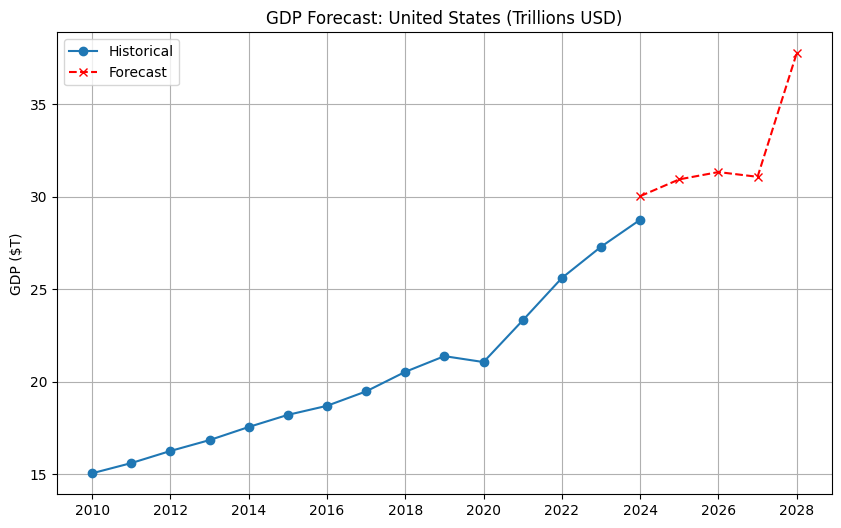

In [18]:
# Ranking Table
final_year = forecast_results['year'].max()
ranking = forecast_results[forecast_results['year'] == final_year].sort_values('forecast_mean', ascending=False).head(10)

ranking['gdp_trillions'] = ranking['forecast_mean'] / 1e12
print(f"--- Projected Top 10 Economies in {final_year} ---")
display(ranking[['country', 'year', 'gdp_trillions', 'model_weights']])

# Optional: Plot for a specific country (e.g., top 1)
top_country = ranking.iloc[0]['country']
country_data = df[df['country'] == top_country]
country_forecast = forecast_results[forecast_results['country'] == top_country]

plt.figure(figsize=(10, 6))
plt.plot(country_data['date'], country_data['GDP']/1e12, label='Historical', marker='o')
plt.plot(pd.to_datetime(country_forecast['year'], format='%Y'), country_forecast['forecast_mean']/1e12, label='Forecast', linestyle='--', marker='x', color='red')
plt.title(f"GDP Forecast: {top_country} (Trillions USD)")
plt.ylabel("GDP ($T)")
plt.legend()
plt.grid(True)
plt.show()